# **Redes Neuronales Profundas**

### usaremos PyTorch para crear una red neuronal simple que predice el resultado de un partido deportivo basándose en ciertas características relevantes. 

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento.

In [56]:
import pandas as pd
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as td


In [57]:
partidos = pd.read_csv('../../data/partidos_limpio.csv')
partidos.head()

,Season,Round,Day,Date,Results,Home,Country (Home),Points (Home),Score (Home),Score (Away),...,MP_away,Starts_away,Gls_away,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away
0,2023-2024,Round of 16,Tue,2024-02-13,A,RB Leipzig,Germany,88.736698,0,1,...,10.0,110.0,20.0,17.0,37.0,20.0,0.0,1.0,18.0,0.0
1,2023-2024,Round of 16,Tue,2024-02-13,A,FC Copenhagen,Denmark,80.431647,1,3,...,10.0,110.0,28.0,20.0,48.0,25.0,3.0,3.0,10.0,0.0
2,2023-2024,Round of 16,Wed,2024-02-14,H,Paris S-G,France,114.334580,2,0,...,8.0,88.0,8.0,5.0,13.0,8.0,0.0,1.0,18.0,0.0
3,2023-2024,Round of 16,Wed,2024-02-14,H,Lazio,Italy,99.943311,1,0,...,10.0,110.0,18.0,14.0,32.0,16.0,2.0,2.0,13.0,1.0
4,2023-2024,Round of 16,Tue,2024-02-20,D,PSV Eindhoven,The Netherlands,98.784903,1,1,...,10.0,110.0,15.0,12.0,27.0,14.0,1.0,1.0,16.0,0.0


### Preparación de los datos.

En una red neuronal profunda (DNN), las variables de entrada (características o predictores) pueden ser tanto numéricas como categóricas. A diferencia de algunos modelos tradicionales como la regresión logística, que generalmente requieren que todas las variables de entrada sean numéricas, las DNN tienen la flexibilidad de manejar entradas de diferentes tipos.

Por lo tanto simplemente tenemos que eliminar las filas que contengan datos nulos.

In [58]:
# Columnas a modificar
cols = ['Season', 'Round', 'Day', 'Results', 'Home', 'Away', 'Country (Home)', 'Country (Away)', 'Venue', 'Referee']

# Inicializamos el label encoder
label_encoder = LabelEncoder()

# Creamos un diccionario para guardar los mapeos
mapping = {}

# Iteramos sobre las columnas y las transformamos
for col in cols:
    # Concatenamos los valores necesarios
    if col in ['Home', 'Away']:
        if 'Squad' not in mapping:
            name = 'Squad'
            squad = pd.concat([partidos['Home'], partidos['Away']])
            label_encoder.fit(squad)      
    elif col in ['Country (Home)', 'Country (Away)']:
        if 'Country' not in mapping:
            name = 'Country'
            country = pd.concat([partidos['Country (Home)'], partidos['Country (Away)']])
            label_encoder.fit(country)
    else:
        name = col
        label_encoder.fit(partidos[col])
    
    # Transformamos los valores 
    partidos[col] = label_encoder.transform(partidos[col])
    
    # Creamos un mapeo de los valores
    mapping[name] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Transformamos la columna 'Date' a datetime
partidos['Date'] = pd.to_datetime(partidos['Date'])

# Separar la fecha en año, mes y día
partidos['Year'] = partidos['Date'].dt.year
partidos['Month'] = partidos['Date'].dt.month
partidos['Number Day'] = partidos['Date'].dt.day # Lo llamamos 'Number Day' para evitar confusiones con la columna 'Day' que ya existe

# Eliminamos la columna 'Date'
partidos.drop('Date', axis=1, inplace=True)

# Verificamos los cambios
partidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          598 non-null    int32  
 1   Round           598 non-null    int32  
 2   Day             598 non-null    int32  
 3   Results         598 non-null    int32  
 4   Home            598 non-null    int32  
 5   Country (Home)  598 non-null    int32  
 6   Points (Home)   598 non-null    float64
 7   Score (Home)    598 non-null    int64  
 8   Score (Away)    598 non-null    int64  
 9   Points (Away)   598 non-null    float64
 10  Country (Away)  598 non-null    int32  
 11  Away            598 non-null    int32  
 12  Venue           598 non-null    int32  
 13  Referee         598 non-null    int32  
 14  # Pl_home       538 non-null    float64
 15  Age_home        538 non-null    float64
 16  MP_home         538 non-null    float64
 17  Starts_home     538 non-null    flo

In [59]:
partidos = partidos.dropna()

In [60]:
X = partidos.drop(labels=['Results', 'Score (Home)', 'Score (Away)', 'Referee'], axis=1)
y = partidos['Results']

# Estandarizamos los datos

# Columnas a estandarizar
cols = [['Points (Home)', 'Points (Away)', '# Pl_home','Age_home','MP_home','Starts_home','Gls_home','Ast_home','G+A_home','G-PK_home','PK_home','PKatt_home','CrdY_home','CrdR_home','# Pl_away','Age_away','MP_away','Starts_away','Gls_away','Ast_away','G+A_away','G-PK_away','PK_away','PKatt_away','CrdY_away','CrdR_away']]

# Se recorren las columnas especificadas y se escala cada una
for col in cols:
    X[col] = scale(X[col])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)

In [62]:
# Set random seed for reproducability
torch.manual_seed(0)

In [63]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(X_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [64]:
'''features = X.columns
penguin_classes = list(mapping['Results'].keys())'''

"features = X.columns\npenguin_classes = list(mapping['Results'].keys())"

In [65]:
# Number of hidden layer nodes
hl = 10

# Define the neural network
class ResultsNet(nn.Module):
    def __init__(self):
        super(ResultsNet, self).__init__()
        self.fc1 = nn.Linear(len(X.columns), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(list(mapping['Results'].keys())))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Create a model instance from the network
model = ResultsNet()
print(model)

ResultsNet(
  (fc1): Linear(in_features=37, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


In [66]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1


Training set: Average loss: 12.446514
Validation set: Average loss: 8.636603, Accuracy: 46/162 (28%)

Epoch: 2
Training set: Average loss: 6.611015
Validation set: Average loss: 4.473939, Accuracy: 46/162 (28%)

Epoch: 3
Training set: Average loss: 3.447216
Validation set: Average loss: 2.446518, Accuracy: 46/162 (28%)

Epoch: 4
Training set: Average loss: 2.012961
Validation set: Average loss: 1.580421, Accuracy: 46/162 (28%)

Epoch: 5
Training set: Average loss: 1.387955
Validation set: Average loss: 1.208009, Accuracy: 46/162 (28%)

Epoch: 6
Training set: Average loss: 1.143771
Validation set: Average loss: 1.087807, Accuracy: 46/162 (28%)

Epoch: 7
Training set: Average loss: 1.070570
Validation set: Average loss: 1.055139, Accuracy: 79/162 (49%)

Epoch: 8
Training set: Average loss: 1.048585
Validation set: Average loss: 1.044075, Accuracy: 79/162 (49%)

Epoch: 9
Training set: Average loss: 1.039938
Validation set: Average loss: 1.039723, Accuracy: 79/162 (49%)

Epoch: 10
Training

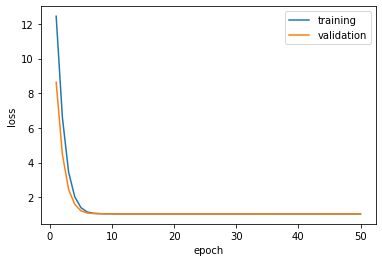

In [67]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [68]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[-1.23082101e-03  8.81907791e-02 -1.35307789e-01 -1.20987624e-01
  -6.33189827e-02  4.40848023e-02 -3.25725973e-03  1.30350217e-01
  -1.45894289e-02  4.35020328e-02 -4.96835187e-02 -3.23151499e-02
  -1.57058313e-01 -1.08878508e-01 -6.77690580e-02  6.08992577e-03
   6.49927109e-02  9.86431390e-02 -1.11452825e-01 -7.15896487e-02
   5.97125292e-02  1.36514947e-01 -3.38333398e-02  1.23021707e-01
  -2.64983773e-02  1.73957348e-02  1.48859367e-01 -1.52508065e-01
  -1.03495397e-01 -4.16201055e-02 -6.40827194e-02  1.42040864e-01
  -1.06560074e-01 -7.56782591e-02 -1.14855781e-01 -1.53969675e-01
  -9.59663391e-02]
 [ 1.41317055e-01  7.33578503e-02  7.96796679e-02  8.64599645e-03
  -8.42846483e-02  2.78137922e-02 -1.53498456e-01 -1.18789151e-01
  -8.47526044e-02  1.03725567e-01  9.63906199e-02 -7.29101300e-02
  -5.93191385e-03  1.05143115e-01  1.63434461e-01  6.52470291e-02
   2.22091228e-02  1.10227272e-01 -9.67985019e-02  3.06347758e-02
  -1.27459437e-01 -1.13942653e-01 -8.4925815

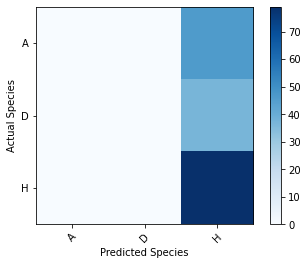

In [69]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(list(mapping['Results'].keys())))
plt.xticks(tick_marks, list(mapping['Results'].keys()), rotation=45)
plt.yticks(tick_marks, list(mapping['Results'].keys()))
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

In [70]:
semis = [['2023-2024', 'Semi-finals', 'Tue', 'Bayern Munich', 'Germany', '107.882298136646', '114.5545351473923', 'Spain', 'Real Madrid', 'Allianz Arena', 23,28.3,10,110,18,14,32,16,2,2,13.0,1.0, 22,28.0,10,110,20,17,37,20,0,1,18.0,0.0, '2024', '4', '30'],
        ['2023-2024', 'Semi-finals', 'Wed', 'Dortmund', 'Germany', '91.17303312629399', '114.33458049886625', 'France', 'Paris S-G', 'Signal Iduna Park', 23,28.0,10,110,15,12,27,14,1,1,16.0,0.0, 21,25.3,10,110,19,12,31,16,3,3,27.0,0.0, '2024', '5', '1'],
        ['2023-2024', 'Semi-finals', 'Tue', 'Paris S-G', 'France', '114.33458049886625', '91.17303312629399', 'Germany', 'Dortmund', 'Parc des Princes', 21,25.3,10,110,19,12,31,16,3,3,27.0,0.0, 23,28.0,10,110,15,12,27,14,1,1,16.0,0.0, '2024', '5', '7'],
        ['2023-2024', 'Semi-finals', 'Wed', 'Real Madrid', 'Spain', '114.5545351473923', '107.882298136646', 'Germany', 'Bayern Munich', 'Estadio Santiago Bernabéu', 22,28.0,10,110,20,17,37,20,0,1,18.0,0.0, 23,28.3,10,110,18,14,32,16,2,2,13.0,1.0, '2024', '5', '8']]

partidos_cols = partidos.drop(labels=['Results', 'Score (Home)', 'Score (Away)', 'Referee'], axis=1).columns
semis = pd.DataFrame(semis, columns=(partidos_cols))

In [71]:
data = semis.copy()

# Aplicamos mapping a las columnas
for col, col_mapping in mapping.items():
    if col in data.columns:
        data[col] = data[col].map(col_mapping)
    else:
        if col == 'Squad':
            data['Home'] = data['Home'].map(col_mapping)
            data['Away'] = data['Away'].map(col_mapping)
        elif col == 'Country':
            data['Country (Home)'] = data['Country (Home)'].map(col_mapping)
            data['Country (Away)'] = data['Country (Away)'].map(col_mapping)

data.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,20,3,4,7,7,107.882298136646,114.5545351473923,13,50,1,...,17,37,20,0,1,18.0,0.0,2024,4,30
1,20,3,5,16,7,91.17303312629399,114.33458049886625,6,45,77,...,12,31,16,3,3,27.0,0.0,2024,5,1
2,20,3,4,45,6,114.33458049886625,91.17303312629399,7,16,71,...,12,27,14,1,1,16.0,0.0,2024,5,7
3,20,3,5,50,13,114.5545351473923,107.882298136646,7,7,30,...,14,32,16,2,2,13.0,1.0,2024,5,8


In [74]:
for col in data.columns:
    data[col] = data[col].astype(float)

In [76]:
# Get a prediction for the new data sample
x = torch.Tensor(data.values).float()
_, predicted = torch.max(model(x).data, 1)

# Crear una lista de predicciones
predictions = [list(mapping['Results'].keys())[i] for i in predicted]

print('Predictions:', predictions)

Predictions: ['H', 'H', 'H', 'H']
